# 一連の予測を行うNotebook
## ライブラリのインポート

In [4]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import optuna

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from conf.config import CFG, DIRS

from utils.load_datas import load_all_datas
from utils.feature_enginerring2 import feature_engineering_prototype2
from utils.validations import cross_val_train, walk_forward_time_val, time_cross_val
from utils.lgb_trial import new_tuning, time_cross_val_tuning

## 設定

In [5]:
config = CFG()

# データのロード
train_df, test_df = load_all_datas()

# 変換
train_df, test_df = feature_engineering_prototype2(train_df, test_df, config)

# 切り分け
X_train_pp = train_df.loc[:, config.FEATURES]
y_train = train_df.loc[:, config.TARGET]
X_test_pp = test_df.loc[:, config.FEATURES]


## パラメータチューニング

In [ ]:
study = optuna.create_study(study_name="optimization_lbg", direction="minimize")
study.optimize(lambda trial: time_cross_val_tuning(trial, X_train_pp, y_train, config), n_trials=50)

In [7]:
print(f"Number of finished trials: {len(study.trials)}")
print(f"Beset Trial: {study.best_trial.params}")

Number of finished trials: 50
Beset Trial: {'learning_rate': 0.07345095902989462, 'max_depth': 10, 'num_leaves': 27, 'min_data_in_leaf': 15, 'bagging_fraction': 0.8801264255284491, 'feature_fraction': 0.5199378402478978}


## テストデータの予測

In [21]:
# 最適化されたパラメータ
optimized_params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "random_state": 42,
        'learning_rate': 0.07345095902989462, 
        'max_depth': 10,
        'num_leaves': 27,
        'min_data_in_leaf': 15, 
        'bagging_fraction': 0.8801264255284491, 
        'feature_fraction': 0.5199378402478978
    }

# 再度訓練を行う
dtrain = lgb.Dataset(data=X_train_pp, label=y_train, feature_name=config.FEATURES, categorical_feature=config.CAT_FEATURES)

optimized_model = lgb.train(optimized_params, dtrain, num_boost_round=180)


In [20]:
time_cross_val(X_train_pp, y_train, optimized_params, config)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's rmse: 3352.24
Fold: 2   Train RMSLE: 1190.4302  Val RMSLE: 3352.2384
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	valid_0's rmse: 4057.07
Fold: 3   Train RMSLE: 1333.9656  Val RMSLE: 4057.0672
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 4461.56
Fold: 4   Train RMSLE: 1405.2807  Val RMSLE: 4461.5604
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's rmse: 4406.14
Fold: 5   Train RMSLE: 2076.7918  Val RMSLE: 4406.1448
--------------------------------------------------


[3352.238369079528, 4057.067215959616, 4461.560363200652, 4406.144796536149]

## 特徴量重要性

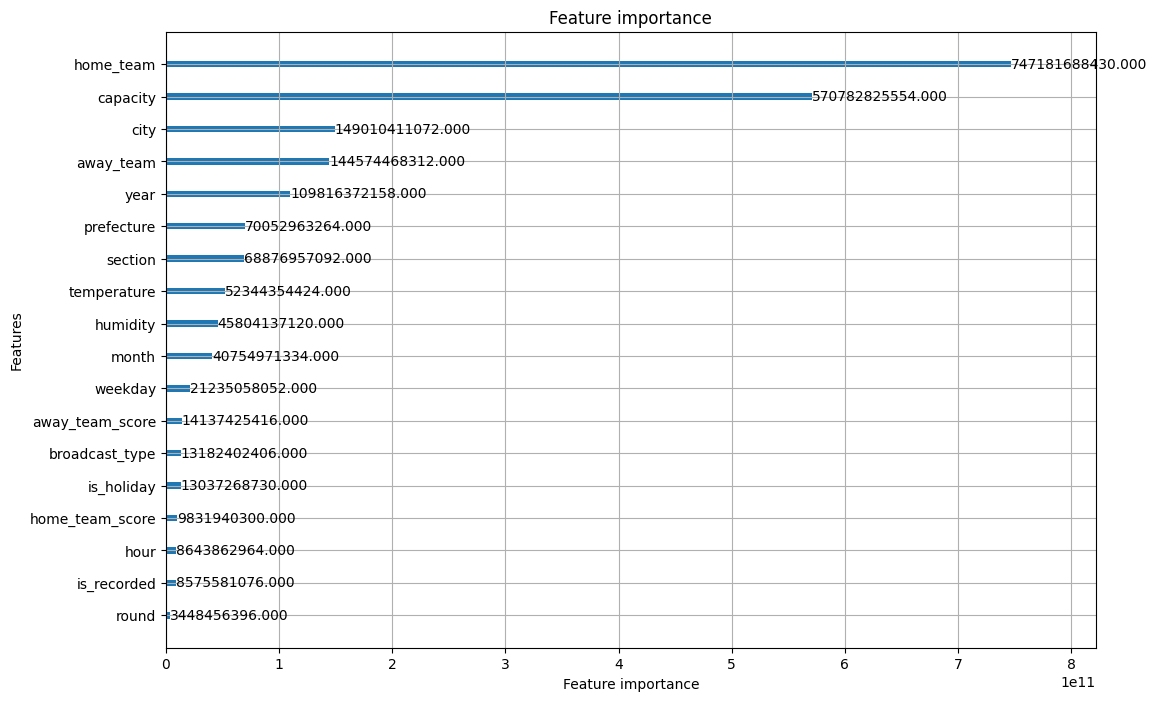

In [22]:
lgb.plot_importance(optimized_model, importance_type="gain", figsize=(12, 8))
plt.show()

## submitの作成

In [23]:
# 予測
test_preds = optimized_model.predict(X_test_pp)

In [24]:
sub = pd.DataFrame({
    "id": test_df["id"],
    "attendance": test_preds,
})

sub.to_csv(os.path.join(DIRS["OUTPUT"], "submission_prototype2_opt.csv"), index=False, header=None)

結果は**5425.87**となった。<br>
明らかな過学習を起こしている。バリデーションの方法の見直しを行う